In [487]:
import scprep, phate
#dbio

import os

#import sys
#sys.path.append('/home/dan/burkhardt/software/AAnet/')

import AAnet
import network
import numpy as np
import AAtools
import matplotlib.pyplot as plt
import seaborn
import tensorflow as tf
import time
import pickle
from sklearn.decomposition import PCA
from scipy.spatial import procrustes
from sklearn.manifold import MDS
%load_ext autoreload
%autoreload 2
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
basedir = '/data/lab/DataSets/Ryan-TILs/10x-t17010/5prime'
samples = ['062418_TILD0UNSEL', '062418_TILD14PD1NEG', '062418_TILD14PD1POS']
suffix  = 'outs/filtered_gene_bc_matrices/GRCh38/'
data = []
for sample in samples:
    data.append(scprep.io.load_10X(os.path.join(basedir, sample, suffix), gene_labels='both', sparse=False))

In [3]:
t_cell_expression, batch_labels = scprep.utils.combine_batches(data, batch_labels=['Input', 'PDL1-', 'PDL1+'], append_to_cell_names=True)

In [4]:
batch_cdict = {'Input':'#5c3b6f',
               'PDL1+':'#d84c73',
               'PDL1-':'#34a7b2'}

batch_cvec = np.array([batch_cdict[b] for b in batch_labels])

In [5]:
t_cell_expression = scprep.filter.remove_rare_genes(t_cell_expression, min_cells=10)

In [6]:
libsize=t_cell_expression.sum(axis=1)

Text(0.5, 1.0, 'Library size')

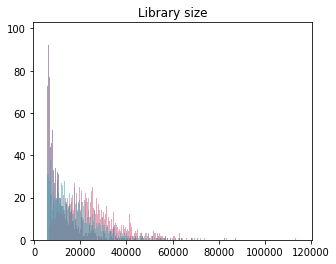

In [7]:
fig, ax = plt.subplots(1,figsize=(5,4))
for sample in np.unique(batch_labels):
    color = batch_cdict[sample]
    ax.hist(libsize.iloc[batch_labels == sample], bins=1000, range=(5000,115000), color=color, alpha=0.5)
    
    #scprep.plot.generate_legend(batch_cdict, ax)
    
ax.set_title('Library size')

In [8]:
t_cell_expression = scprep.filter.filter_library_size(t_cell_expression, cutoff=50000, keep_cells='below')

In [9]:
t_cell_data_ln = scprep.normalize.library_size_normalize(t_cell_expression)

In [10]:
mito_genes = scprep.utils.get_gene_set(t_cell_expression, starts_with='MT-')

mito_expression = t_cell_data_ln['MT-CO1 (ENSG00000198804)']

In [11]:
t_cell_data_ln = scprep.filter.filter_values(t_cell_data_ln, mito_expression, percentile=95, keep_cells='below')

In [12]:
batch_labels = np.array([bc.split('_')[1] for bc in t_cell_data_ln.index])

In [567]:
label_encoder = LabelEncoder()
labels_int = label_encoder.fit_transform(batch_labels)
print(integer_encoded)
onehot_encoder = OneHotEncoder(sparse=False)
labels_int = labels_int.reshape(len(labels_int), 1)
labels_oh = onehot_encoder.fit_transform(labels_int)
labels_oh = (labels_oh * 2) - 1
labels_oh

[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]


/usr/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


array([[ 1., -1., -1.],
       [ 1., -1., -1.],
       [ 1., -1., -1.],
       ...,
       [-1.,  1., -1.],
       [-1.,  1., -1.],
       [-1.,  1., -1.]])

In [502]:
print(labels_int.shape)
print(labels_oh.shape)

(11566, 1)
(11566, 3)


In [503]:
t_cell_data_sq = scprep.transform.sqrt(t_cell_data_ln)

In [504]:
t_cell_data_pca = scprep.reduce.pca(t_cell_data_sq, n_pca=100)

In [16]:
#t_cell_data_pca[:,i:i+1]

TypeError: inner() got multiple values for argument 'ax'

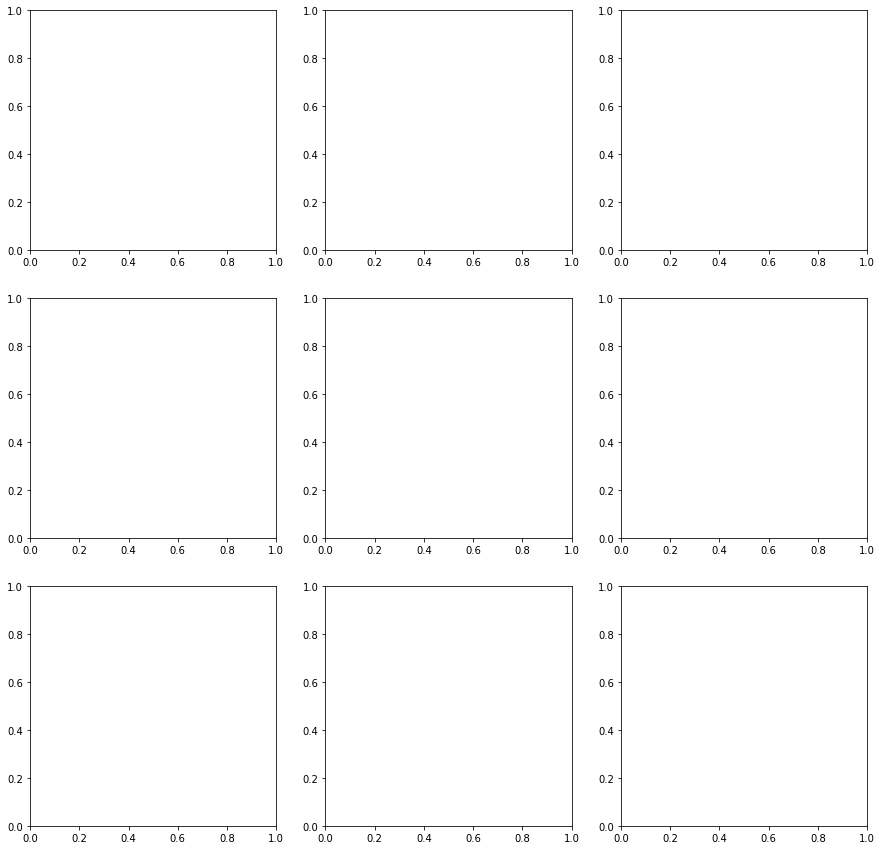

In [505]:
fig, axes = plt.subplots(3,3, figsize=(15, 15))

for i, ax in enumerate(axes.flatten()):
    ax = plt.scatter(t_cell_data_pca[:,i], t_cell_data_pca[:,i:i+1], ax=ax)
    ax.set_title('PCA')
    ax.set_xlabel('PC{}'.format(i))
    ax.set_ylabel('PC{}'.format(i))

fig.tight_layout()

In [506]:
phate_op = phate.PHATE(gamma=0, n_jobs=16)
Y = phate_op.fit_transform(t_cell_data_pca)

Calculating PHATE...
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 8.70 seconds.
    Calculating affinities...
    Calculated affinities in 0.19 seconds.
  Calculated graph and diffusion operator in 8.91 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.02 seconds.
    Calculating KMeans...
    Calculated KMeans in 20.37 seconds.
  Calculated landmark operator in 22.94 seconds.
  Calculating optimal t...
    Automatically selected t = 23
  Calculated optimal t in 0.80 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.31 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 15.98 seconds.
Calculated PHATE in 48.94 seconds.


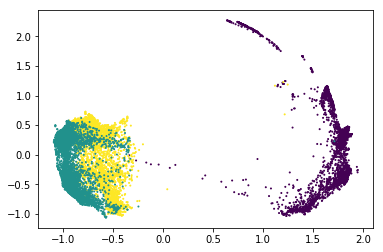

In [510]:
plt.scatter(Y[:,0], Y[:,1], s=1, c=labels_int[:,0])
plt.show()

In [513]:
idx = labels_int[:,0] >= 0
#labels = labels_int[idx]
##labels = labels - 1
#labels = (labels * 2) - 1
#labels = np.reshape(labels, [labels.shape[0], 1])
#print(np.unique(labels))
#print(labels.shape)

In [511]:
labels_int

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [514]:
pdl1_neg_data_sq = t_cell_data_sq.iloc[idx]

In [515]:
pdl1_neg_data_pca = scprep.reduce.pca(pdl1_neg_data_sq, n_pca=100)

In [301]:
phate_op = phate.PHATE(n_pca=None, gamma=0, n_jobs=16)
Y_neg = phate_op.fit_transform(pdl1_neg_data_pca)

Calculating PHATE...
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 5.37 seconds.
    Calculating affinities...
    Calculated affinities in 0.27 seconds.
  Calculated graph and diffusion operator in 5.66 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.89 seconds.
    Calculating KMeans...
    Calculated KMeans in 20.90 seconds.
  Calculated landmark operator in 23.20 seconds.
  Calculating optimal t...
    Automatically selected t = 26
  Calculated optimal t in 0.82 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.28 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 7.03 seconds.
Calculated PHATE in 37.01 seconds.


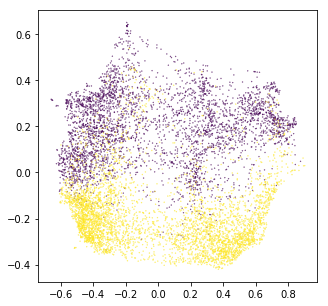

In [302]:
fig, ax = plt.subplots(1, figsize=(5,5))
plt.scatter(Y_neg[:,0], Y_neg[:,1], c=labels, s=.1)
plt.show()

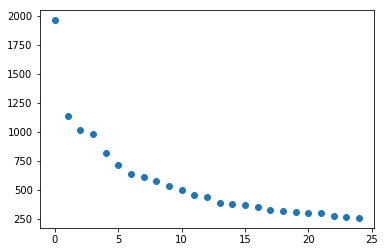

In [516]:
data, X_mu, U, S = AAnet.AAnet.pcasvd([], pdl1_neg_data_sq.values, k=25)
plt.scatter(range(25), S)

In [517]:
sigma = np.std(data[:,0])
data = data / sigma

In [518]:
data.shape

(11566, 25)

In [519]:
np.std(data, axis=0)

array([1.        , 0.57995237, 0.5179309 , 0.5001343 , 0.41749671,
       0.36486094, 0.32571474, 0.3103625 , 0.29145437, 0.27242534,
       0.25202759, 0.2324805 , 0.22347642, 0.19613859, 0.19175962,
       0.18570235, 0.17809666, 0.16754109, 0.16308422, 0.1559393 ,
       0.15231539, 0.15111498, 0.13907214, 0.13483985, 0.13106297])

In [736]:
# AAnet params
num_at = 3
noise_z_std = 0.0
z_dim = [256, 128, 64]
#z_dim = [] # linear AA
act_out = None #tf.nn.tanh
#act_out = None # linear last layer
input_dim = data.shape[1]
c_dim = labels_oh.shape[1]
#c_dim = 0

In [737]:
# AAnet
enc_net = network.Encoder(num_at=num_at, z_dim=z_dim)
dec_net = network.Decoder(x_dim=input_dim, noise_z_std=noise_z_std, z_dim=z_dim, act_out=act_out)
model = AAnet.AAnet(enc_net, dec_net, c_dim=c_dim)

In [738]:
idx = labels_int[:,0]

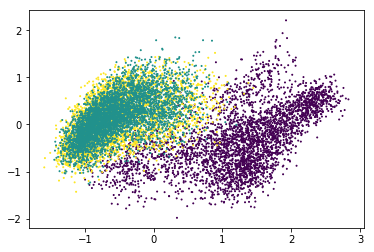

In [739]:
# plot PCA
plt.scatter(data[:,0], data[:,1], s=1, c=idx)
plt.show()

#### Train

In [740]:
model.train(data, batch_size=1024, num_batches=5000, cond=labels_oh)

Iter [       0] Time [0.1714] loss [0.1195]
Iter [     500] Time [2.5559] loss [0.0332]
Iter [    1000] Time [4.9966] loss [0.0313]
Iter [    1500] Time [7.4458] loss [0.0304]
Iter [    2000] Time [9.9007] loss [0.0294]
Iter [    2500] Time [12.3535] loss [0.0288]
Iter [    3000] Time [14.7596] loss [0.0283]
Iter [    3500] Time [17.1950] loss [0.0276]
Iter [    4000] Time [19.6303] loss [0.0278]
Iter [    4500] Time [22.0544] loss [0.0270]
Iter [    4999] Time [24.4937] loss [0.0268]
done.


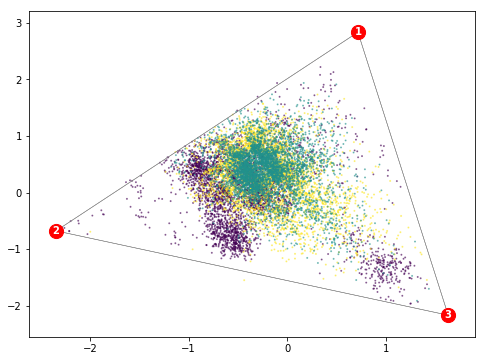

In [741]:
model.plot_at_mds(data, c=idx)

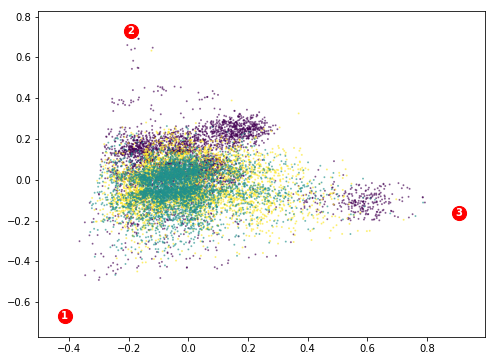

In [742]:
model.plot_at_pca_single(data, c=idx)

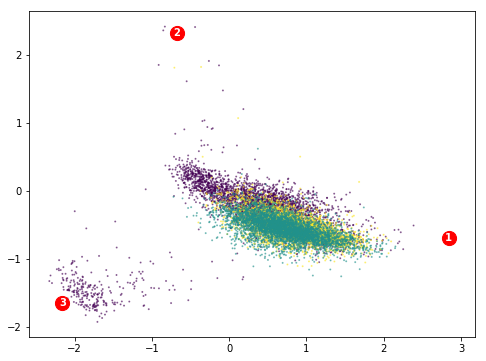

In [743]:
model.plot_pca_ats_data(data, c=idx)

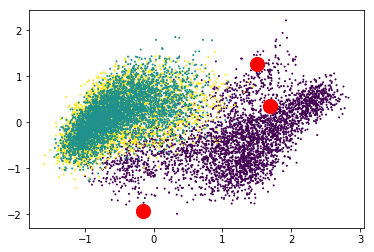

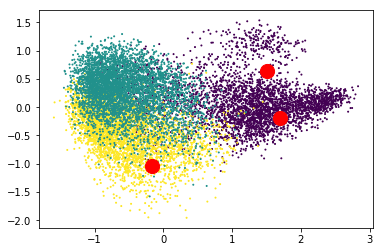

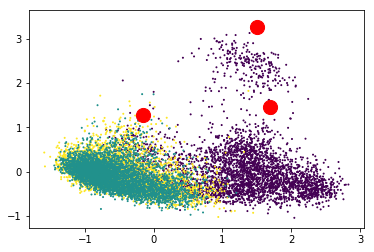

In [744]:
# plot PCA with ATs
ats_x = model.get_ats_x()
plt.scatter(data[:,0], data[:,1], s=1, c=idx)
plt.scatter(ats_x[:,0], ats_x[:,1], s=200, alpha=1, c='r')
plt.show()
plt.scatter(data[:,0], data[:,2], s=1, c=idx)
plt.scatter(ats_x[:,0], ats_x[:,2], s=200, alpha=1, c='r')
plt.show()
plt.scatter(data[:,0], data[:,3], s=1, c=idx)
plt.scatter(ats_x[:,0], ats_x[:,3], s=200, alpha=1, c='r')
plt.show()

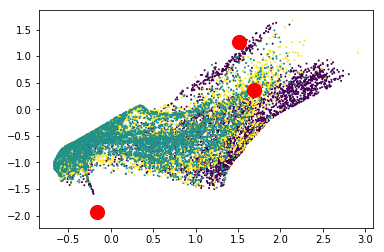

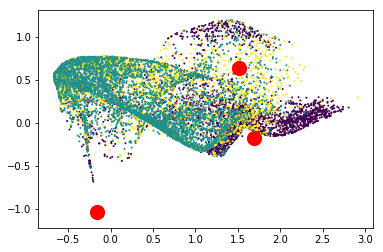

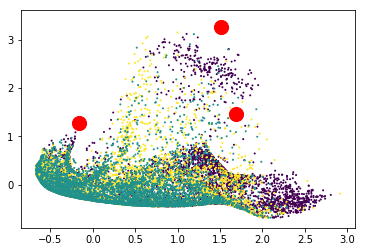

In [745]:
# plot PCA recon with ATs
ats_x = model.get_ats_x()
data_recon = model.at2data(model.data2at(data))
plt.scatter(data_recon[:,0], data_recon[:,1], s=1, c=idx)
plt.scatter(ats_x[:,0], ats_x[:,1], s=200, alpha=1, c='r')
plt.show()
plt.scatter(data_recon[:,0], data_recon[:,2], s=1, c=idx)
plt.scatter(ats_x[:,0], ats_x[:,2], s=200, alpha=1, c='r')
plt.show()
plt.scatter(data_recon[:,0], data_recon[:,3], s=1, c=idx)
plt.scatter(ats_x[:,0], ats_x[:,3], s=200, alpha=1, c='r')
plt.show()

In [746]:
# PHATE on reconstruction
data_recon = model.at2data(model.data2at(data))
phate_op = phate.PHATE(n_pca=None, gamma=0, n_jobs=16)
Y_recon = phate_op.fit_transform(data_recon)

Calculating PHATE...
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 1.23 seconds.
    Calculating affinities...
    Calculated affinities in 0.14 seconds.
  Calculated graph and diffusion operator in 1.38 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.52 seconds.
    Calculating KMeans...
    Calculated KMeans in 22.06 seconds.
  Calculated landmark operator in 24.01 seconds.
  Calculating optimal t...
    Automatically selected t = 51
  Calculated optimal t in 0.85 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.38 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 121.74 seconds.
Calculated PHATE in 148.38 seconds.


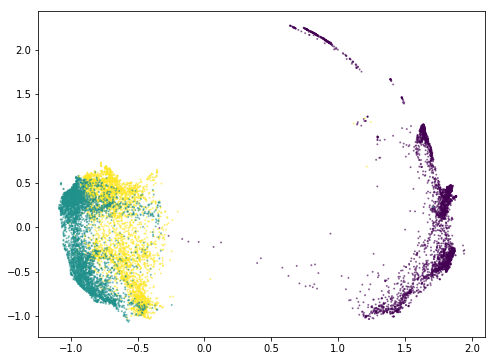

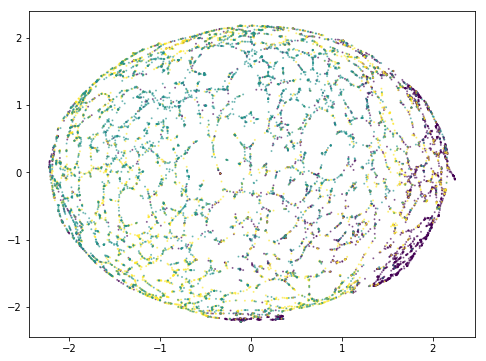

In [747]:
fig, ax = plt.subplots(1, figsize=(8,6))
plt.scatter(Y[:,0], Y[:,1], c=idx, s=1, alpha=0.5)
plt.show()
fig, ax = plt.subplots(1, figsize=(8,6))
plt.scatter(Y_recon[:,0], Y_recon[:,1], c=idx, s=1, alpha=0.5)
plt.show()

In [149]:
# get ATs
ats_x = model.get_ats_x()
print(ats_x.shape)
# project back from PCA to input space
ats_x_orig = ats_x @ U.T + X_mu;
print(ats_x_orig.shape)

(3, 25)
(3, 18553)


In [ ]:
data_nu = np.concatenate([data, ats_x])

In [ ]:
phate_op = phate.PHATE(n_pca=None, gamma=0, n_jobs=16)
Y_neg = phate_op.fit_transform(data_nu)


In [ ]:
plt.scatter(Y_neg[:-num_at,0], Y_neg[:-num_at,1], c=batch_cdict['PDL1-'], s=5)
plt.scatter(Y_neg[-num_at:,0], Y_neg[-num_at:,1], c='r', s=200)
plt.show()

In [ ]:
model.plot_at(data, c=idx)

In [ ]:
data_z = model.data2at(data)
ats_z = model.get_ats()
data_z_nu = np.concatenate([data_z, ats_z])

In [ ]:
phate_op = phate.PHATE(n_pca=None, gamma=0, n_jobs=16)
Y_neg_z = phate_op.fit_transform(data_z_nu)


In [ ]:
plt.scatter(Y_neg_z[:-num_at,0], Y_neg_z[:-num_at,1], c=batch_cdict['PDL1-'], s=5)
plt.scatter(Y_neg_z[-num_at:,0], Y_neg_z[-num_at:,1], c='r', s=200)
plt.show()

In [ ]:
data_recon = model.at2data(model.data2at(data))
data_recon_nu = np.concatenate([data_recon, ats_x])

In [ ]:
phate_op = phate.PHATE(n_pca=None, gamma=0, n_jobs=16)
Y_neg_recon = phate_op.fit_transform(data_recon_nu)

In [ ]:
fig, ax = plt.subplots(1, figsize=(5,5))

scprep.plot.scatter2d(Y_neg_recon[:-num_at], c=batch_cdict['PDL1-'], ax=ax, s=5)
scprep.plot.scatter2d(Y_neg_recon[-num_at:], c='r', ax=ax, s=200)

dbio.style_phate(ax)

In [ ]:
pc_op = PCA(100)
pcs = pc_op.fit_transform(pdl1_neg_data_sq)

In [ ]:
fig, ax = plt.subplots(1, figsize=(6,5))

# plot explained variance as a fraction of the total explained variance
ax.plot(pc_op.explained_variance_/pc_op.explained_variance_.sum())

# mark the 100th principal component
ax.axvline(50, c='k', linestyle='--')

ax.set_xlabel('PC index')
ax.set_ylabel('% explained variance')
ax.set_title('Scree plot')

fig.tight_layout()

In [ ]:
expanded_mask = np.array([b.startswith('PDL') for b in batch_labels])

In [ ]:
exp_data_sq = t_cell_data_sq[np.array([b.startswith('PDL') for b in batch_labels])]

In [ ]:
exp_data_pcs = scprep.reduce.pca(exp_data_sq, n_components=250)

In [ ]:
phate_op = phate.PHATE(n_pca=None, gamma=0, n_jobs=16)
Y_exp = phate_op.fit_transform(exp_data_pcs)


In [ ]:
len(batch_cvec[expanded_mask])

In [ ]:
Y.shape

In [ ]:
fig, ax = plt.subplots(1, figsize=(5,5))
scprep.plot.scatter2d(Y_exp, c=batch_cvec[expanded_mask], ax=ax, s=5)
dbio.style_phate(ax)


In [ ]:
scprep.utils.get_gene_set(exp_data_sq, starts_with='CD274')

In [ ]:
fig, ax = plt.subplots(1, figsize=(5,5))
cvec = exp_data_sq['CD274 (ENSG00000120217)']
r = np.argsort(cvec)
ax.scatter(Y_exp[:,0][r], Y_exp[:,1][r], c=cvec[r], s=5, cmap='inferno')
dbio.style_phate(ax)

ax.set_title('CD274')

In [ ]:
phate_op = phate.PHATE(n_components=3, n_pca=None, gamma=0, n_jobs=16)
Y3_exp = phate_op.fit_transform(exp_data_pcs)

In [ ]:
%matplotlib notebook
scprep.plot.scatter3d(Y3_exp, c=batch_cvec[expanded_mask], s=5)
